In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values(0) <= split_date].copy(), \
           data.loc[data.index.get_level_values(0) >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

#### 1. Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

In [3]:
data = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         2667 non-null   float64
 1   year             2667 non-null   int64  
 2   month            2667 non-null   int64  
 3   dayofmonth       2667 non-null   int64  
 4   quarter          2667 non-null   int64  
 5   dayofyear        2667 non-null   int64  
 6   weekofyear       2667 non-null   int64  
 7   dayofweek        2667 non-null   int64  
 8   is_holiday       2667 non-null   int64  
 9   is_prev_holiday  2667 non-null   int64  
 10  is_next_holiday  2667 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


In [5]:
min_d=min(data.index)
min_d

Timestamp('2010-09-01 00:00:00')

In [6]:
max_d=max(data.index)
max_d

Timestamp('2019-09-01 00:00:00')

In [7]:
data.head(5)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [8]:
data.tail(5)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2019-08-27,59.59,2019,8,27,3,239,35,1,0,0,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0,0,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0,0,0
2019-08-30,59.19,2019,8,30,3,242,35,4,0,0,0
2019-09-01,58.84,2019,9,1,3,244,35,6,0,1,0


In [9]:
df = data.copy()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


<AxesSubplot:xlabel='Дата'>

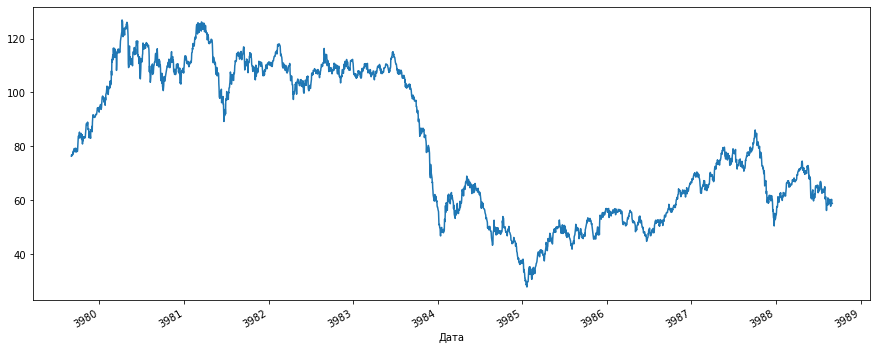

In [10]:
df['Значение'].plot(figsize=(15, 6))

In [11]:
range_dates = pd.date_range(min_d,max_d, freq="D")
range_dates

DatetimeIndex(['2010-09-01', '2010-09-02', '2010-09-03', '2010-09-04',
               '2010-09-05', '2010-09-06', '2010-09-07', '2010-09-08',
               '2010-09-09', '2010-09-10',
               ...
               '2019-08-23', '2019-08-24', '2019-08-25', '2019-08-26',
               '2019-08-27', '2019-08-28', '2019-08-29', '2019-08-30',
               '2019-08-31', '2019-09-01'],
              dtype='datetime64[ns]', length=3288, freq='D')

In [12]:
df_full_dates = pd.DataFrame(index=range_dates)
df_full_dates['Дата'] = df_full_dates.index 

In [13]:
df_full_dates

,Дата
2010-09-01,2010-09-01
2010-09-02,2010-09-02
2010-09-03,2010-09-03
2010-09-04,2010-09-04
2010-09-05,2010-09-05
...,...
2019-08-28,2019-08-28
2019-08-29,2019-08-29
2019-08-30,2019-08-30
2019-08-31,2019-08-31


In [14]:
df = pd.merge(df_full_dates, df, how='left',  left_index=True, right_index=True)

In [15]:
df

,Дата,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
2010-09-01,2010-09-01,76.37,2010.0,9.0,1.0,3.0,244.0,35.0,2.0,0.0,0.0,0.0
2010-09-02,2010-09-02,76.89,2010.0,9.0,2.0,3.0,245.0,35.0,3.0,0.0,0.0,0.0
2010-09-03,2010-09-03,76.57,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.0,0.0,0.0
2010-09-04,2010-09-04,76.62,2010.0,9.0,4.0,3.0,247.0,35.0,5.0,0.0,0.0,0.0
2010-09-05,2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-28,2019-08-28,59.84,2019.0,8.0,28.0,3.0,240.0,35.0,2.0,0.0,0.0,0.0
2019-08-29,2019-08-29,60.37,2019.0,8.0,29.0,3.0,241.0,35.0,3.0,0.0,0.0,0.0
2019-08-30,2019-08-30,59.19,2019.0,8.0,30.0,3.0,242.0,35.0,4.0,0.0,0.0,0.0
2019-08-31,2019-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.fillna(method='pad', inplace=True)

<AxesSubplot:>

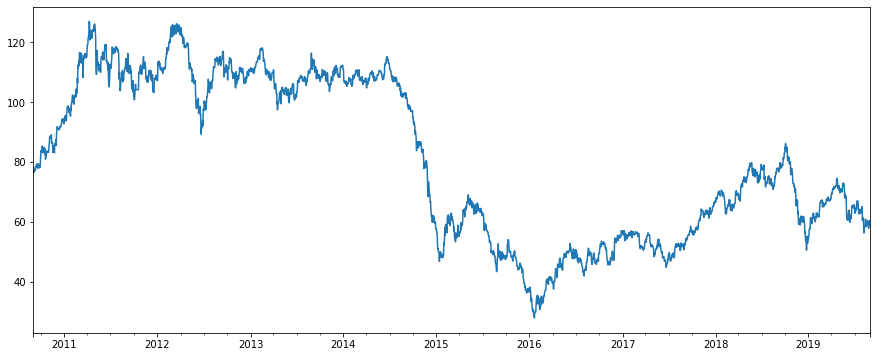

In [17]:
df['Значение'].plot(figsize=(15, 6))

In [18]:
df['Diff1'] = df['Значение'].diff().fillna(0)

<AxesSubplot:>

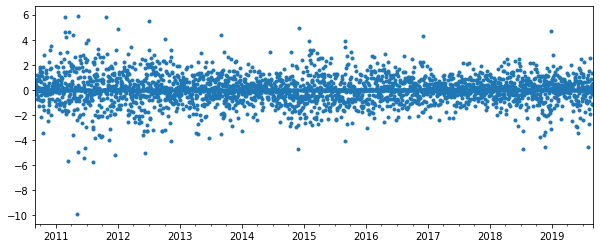

In [19]:
df['Diff1'].plot(figsize=(10, 4), style='.')

#### 2. Добавьте первые разности по стоимости доллара и евро к рублю

В курсах валют отсутствуют данные за выходные дни и новогодние праздники, поэтому сначала сделаем ресемплинг датасетов отдельно, а после соединим

In [20]:
df_usd = pd.read_excel('RC_F01_09_2010_T01_09_2019_usd.xlsx', index_col=[1], parse_dates=[1])
df_usd.drop(['nominal', 'cdx'], axis=1, inplace=True)
df_usd = pd.merge(df_full_dates, df_usd, how='left',  left_index=True, right_index=True)
df_usd.fillna(method='pad', inplace=True)
df_usd.head(5)

,Дата,curs
2010-09-01,2010-09-01,30.8669
2010-09-02,2010-09-02,30.8001
2010-09-03,2010-09-03,30.6858
2010-09-04,2010-09-04,30.6922
2010-09-05,2010-09-05,30.6922


In [21]:
df_usd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Дата    3288 non-null   datetime64[ns]
 1   curs    3288 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 237.1 KB


In [22]:
df_eur = pd.read_excel('RC_F01_09_2010_T01_09_2019_euro.xlsx', index_col=[1], parse_dates=[1])
df_eur.drop(['nominal', 'cdx'], axis=1, inplace=True)
df_eur = pd.merge(df_full_dates, df_eur, how='left',  left_index=True, right_index=True)
df_eur.fillna(method='pad', inplace=True)
df_eur.head(5)

,Дата,curs
2010-09-01,2010-09-01,39.0127
2010-09-02,2010-09-02,39.1654
2010-09-03,2010-09-03,39.2901
2010-09-04,2010-09-04,39.3505
2010-09-05,2010-09-05,39.3505


In [23]:
df_eur.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Дата    3288 non-null   datetime64[ns]
 1   curs    3288 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 237.1 KB


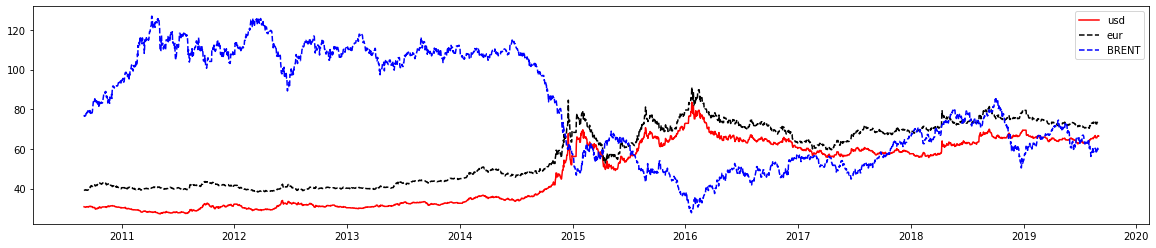

In [24]:
N=df_usd.shape[0] # диапазон графика, недель
plt.figure(figsize =(20,4))
plt.plot(df_usd.index[:N],df_usd['curs'][:N],'r',label ='usd')
plt.plot(df_eur.index[:N],df_eur['curs'][:N],'--k',label ='eur')
plt.plot(df.index[:N],df['Значение'][:N],'--b',label ='BRENT')
plt.legend()
plt.show()

In [25]:
df_usd['usd_diff1'] = df_usd['curs'].diff().fillna(0)
df_eur['eur_diff1'] = df_eur['curs'].diff().fillna(0)

In [26]:
df = df.merge(df_eur['eur_diff1'], left_index=True, right_index=True)
df = df.merge(df_usd['usd_diff1'], left_index=True, right_index=True)

In [27]:
df.head(5)

,Дата,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,Diff1,eur_diff1,usd_diff1
2010-09-01,2010-09-01,76.37,2010.0,9.0,1.0,3.0,244.0,35.0,2.0,0.0,0.0,0.0,0.00,0.0000,0.0000
2010-09-02,2010-09-02,76.89,2010.0,9.0,2.0,3.0,245.0,35.0,3.0,0.0,0.0,0.0,0.52,0.1527,-0.0668
2010-09-03,2010-09-03,76.57,2010.0,9.0,3.0,3.0,246.0,35.0,4.0,0.0,0.0,0.0,-0.32,0.1247,-0.1143
2010-09-04,2010-09-04,76.62,2010.0,9.0,4.0,3.0,247.0,35.0,5.0,0.0,0.0,0.0,0.05,0.0604,0.0064
2010-09-05,2010-09-05,76.63,2010.0,9.0,5.0,3.0,248.0,35.0,6.0,0.0,1.0,0.0,0.01,0.0000,0.0000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2010-09-01 to 2019-09-01
Freq: D
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Дата             3288 non-null   datetime64[ns]
 1   Значение         3288 non-null   float64       
 2   year             3288 non-null   float64       
 3   month            3288 non-null   float64       
 4   dayofmonth       3288 non-null   float64       
 5   quarter          3288 non-null   float64       
 6   dayofyear        3288 non-null   float64       
 7   weekofyear       3288 non-null   float64       
 8   dayofweek        3288 non-null   float64       
 9   is_holiday       3288 non-null   float64       
 10  is_prev_holiday  3288 non-null   float64       
 11  is_next_holiday  3288 non-null   float64       
 12  Diff1            3288 non-null   float64       
 13  eur_diff1        3288 non-null   float64       
 14  usd_diff1     

#### 3. Cделайте ее перрасчет (ресемплинг) в представление по неделям

In [29]:
df_full = df.resample('W').mean()
df_full.drop(['dayofmonth','dayofyear', 'dayofweek', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'],  axis=1, inplace=True)

In [30]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2010-09-05 to 2019-09-01
Freq: W-SUN
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Значение    470 non-null    float64
 1   year        470 non-null    float64
 2   month       470 non-null    float64
 3   quarter     470 non-null    float64
 4   weekofyear  470 non-null    float64
 5   Diff1       470 non-null    float64
 6   eur_diff1   470 non-null    float64
 7   usd_diff1   470 non-null    float64
dtypes: float64(8)
memory usage: 33.0 KB


In [31]:
df_full

,Значение,year,month,quarter,weekofyear,Diff1,eur_diff1,usd_diff1
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,0.052000,0.067560,-0.034940
2010-09-12,77.771429,2010.0,9.000000,3.000000,36.0,0.247143,-0.022686,0.028786
2010-09-19,78.590000,2010.0,9.000000,3.000000,37.0,-0.018571,0.231400,0.026986
2010-09-26,78.558571,2010.0,9.000000,3.000000,38.0,0.101429,0.064057,-0.019229
2010-10-03,81.582857,2010.0,9.428571,3.428571,39.0,0.678571,0.057243,-0.062657
...,...,...,...,...,...,...,...,...
2019-08-04,62.560000,2019.0,7.571429,3.000000,31.0,-0.245714,0.199529,0.216457
2019-08-11,58.262857,2019.0,8.000000,3.000000,32.0,-0.437143,0.187414,0.087429
2019-08-18,58.977143,2019.0,8.000000,3.000000,33.0,0.088571,0.029014,0.105971
2019-08-25,59.415714,2019.0,8.000000,3.000000,34.0,-0.154286,-0.085486,-0.055929


#### 4. Постройте модель предсказания 1-й точки от текущей (h=1).

In [32]:
h = 1
train, test = split_data(df_full, '01-01-2018')
X_train = train.iloc[:-h, :]
y_train = train['Значение'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['Значение'].values[h:]

In [33]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [34]:
y_pred = model_gb.predict(X_test)

In [35]:
df_small = df_full.copy()
df_small.drop(['eur_diff1', 'usd_diff1'],  axis=1, inplace=True)
train, test = split_data(df_small, '01-01-2018')
X_train = train.iloc[:-h, :]
y_train = train['Значение'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['Значение'].values[h:]
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)
y_pred_small = model_gb.predict(X_test)

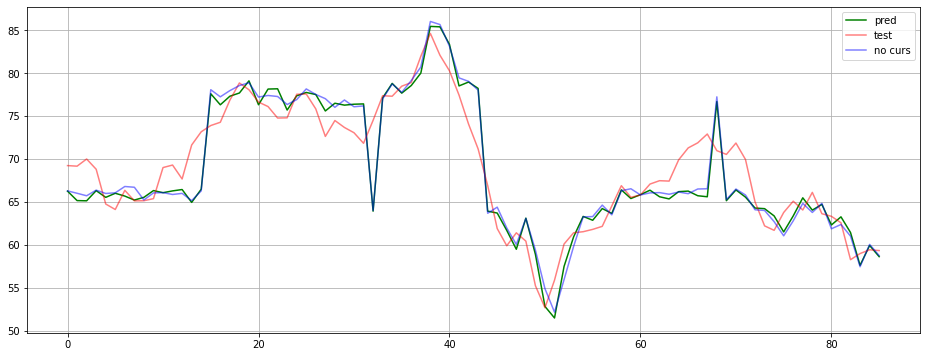

In [36]:
plt.figure(figsize=(16,6))
plt.plot(y_pred, '-g', label='pred')
plt.plot(y_test, '-r', label='test', alpha=0.5)
plt.plot(y_pred_small, '-b', label='no curs', alpha=0.5)
plt.grid()
plt.legend()

In [37]:
mean_absolute_percentage_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred_small)

(3.4428850800193445, 3.594980108301903)

Видимо значени курса валюьты не  влияет на цену в USD нефти 

#### 5. Добавьте еще один экзогенный фактор - любой:)

In [38]:
df_energy = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [39]:
df_energy = df_energy.resample('W').mean()
df_energy.drop(['quarter','weekofyear','month', 'hour', 'year', 'dayofweek', 'dayofyear', 'dayofmonth', 'is_holiday','is_prev_holiday','is_next_holiday'], axis=1, inplace=True)

In [40]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PJME_MW  866 non-null    float64
dtypes: float64(1)
memory usage: 13.5 KB


In [41]:
df_energy = df_energy[min_d:]
df_energy.head(5)

,PJME_MW
Date,
2010-09-05,38345.565476
2010-09-12,31251.017857
2010-09-19,29931.619048
2010-09-26,32824.142857
2010-10-03,30043.898810


In [42]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 414 entries, 2010-09-05 to 2018-08-05
Freq: W-SUN
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PJME_MW  414 non-null    float64
dtypes: float64(1)
memory usage: 6.5 KB


In [43]:
df_with_energy = df_full.merge(df_energy['PJME_MW'], left_index=True, right_index=True)
df_with_energy.head(5)

,Значение,year,month,quarter,weekofyear,Diff1,eur_diff1,usd_diff1,PJME_MW
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,0.052000,0.067560,-0.034940,38345.565476
2010-09-12,77.771429,2010.0,9.000000,3.000000,36.0,0.247143,-0.022686,0.028786,31251.017857
2010-09-19,78.590000,2010.0,9.000000,3.000000,37.0,-0.018571,0.231400,0.026986,29931.619048
2010-09-26,78.558571,2010.0,9.000000,3.000000,38.0,0.101429,0.064057,-0.019229,32824.142857
2010-10-03,81.582857,2010.0,9.428571,3.428571,39.0,0.678571,0.057243,-0.062657,30043.898810


In [44]:
df_with_energy.drop(['weekofyear','quarter','month', 'year'], axis=1, inplace=True)

In [45]:
df_with_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 414 entries, 2010-09-05 to 2018-08-05
Freq: W-SUN
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Значение   414 non-null    float64
 1   Diff1      414 non-null    float64
 2   eur_diff1  414 non-null    float64
 3   usd_diff1  414 non-null    float64
 4   PJME_MW    414 non-null    float64
dtypes: float64(5)
memory usage: 19.4 KB


In [46]:
h = 1
train, test = split_data(df_with_energy, '01-01-2018')
X_train = train.iloc[:-h, :]
y_train = train['Значение'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['Значение'].values[h:]

In [47]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [48]:
y_pred_with_energy = model_gb.predict(X_test)

In [49]:
train, test = split_data(df_with_energy[['Значение', 'Diff1']], '01-01-2018')
X_train = train.iloc[:-h, :]
y_train = train['Значение'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['Значение'].values[h:]

In [50]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [51]:
y_pred = model_gb.predict(X_test)

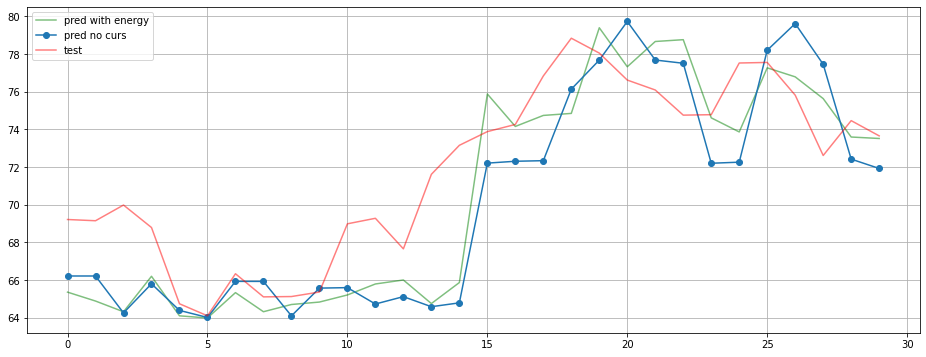

In [52]:
plt.figure(figsize=(16,6))
plt.plot(y_pred_with_energy, '-g', label='pred with energy',alpha=0.5)
plt.plot(y_pred, '-o', label='pred no curs')
plt.plot(y_test, '-r', label='test', alpha=0.5)
plt.grid()
plt.legend()

In [53]:
mean_absolute_percentage_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred_with_energy)

(3.8105075346157062, 3.1847880982784753)

6. Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

Судя по всему признак 'Значение' задавил все остальные признаки, что понятно. Видимо, строить модель с дополнительными экзогенными факторами необходимо отбрасывая значимые признаки